In [1]:
#to get insights to Dubai Housing Market
import pandas as pd
import matplotlib.pyplot as plt
ds = pd.read_csv("DubaiProjectDataSet.csv")
#ds = ds.sample(n=50000, random_state=42)
ds.head()
ds.isnull().sum().sum() #To check no missing values
ds.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210266 entries, 0 to 210265
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   DP_ID                 210266 non-null  int64  
 1   procedure_name        210266 non-null  object 
 2   date                  210266 non-null  object 
 3   property_type         210266 non-null  object 
 4   property_sub_type     210266 non-null  object 
 5   property_usage        210266 non-null  object 
 6   area_name             210266 non-null  object 
 7   building_name         210266 non-null  object 
 8   master_project        210266 non-null  object 
 9   nearest_landmark      210266 non-null  object 
 10  nearest_metro         210266 non-null  object 
 11  nearest_mall          210266 non-null  object 
 12  bedrooms              210266 non-null  object 
 13  parkings              210266 non-null  int64  
 14  built_up_area_(sqft)  210266 non-null  float64
 15  

In [2]:
#date cleaning
ds['date'].head(10) # to check what is the format of date used here dd-mm-yyyy
ds['date'] = pd.to_datetime(ds['date'], dayfirst=True, errors='coerce')
ds['year'] = ds['date'].dt.year
ds['month'] = ds['date'].dt.month
#ds[['date', 'year', 'month',]].head(10)- just in case need to confirm
#ds[ds['date'].isna()].head()- if in case need to check any NaT


#Built-up Area Cleaning
ds[ds['built_up_area_(sqft)'] <= 0] #checking any area negative or zero
ds['built_up_area_(sqft)'].describe()
ds[ds['sale_price_per_foot'] <= 0] #checking impossible values
ds[ds['selling_price'] <= 0] #checking impossible values
ds['bedrooms'].value_counts().head(20) #checking different values of bedroom
ds['parkings'].value_counts()
ds[ds['parkings'] < 0]

#cleaning
ds = ds[ds['built_up_area_(sqft)'] > 0]
ds = ds[ds['selling_price'] > 0]
ds = ds[ds['sale_price_per_foot'] > 0]
ds = ds[ds['parkings'] >= 0]

ds.duplicated().sum()
#checkingpropertytypes
ds['property_type'].unique()
ds['property_type_clean'] = ds['property_type'].str.lower().str.strip()
ds[['property_type','property_type_clean']].head(10)
#checkingpropertysubtypes
ds['property_sub_type'].unique()
def simplify_property(value):
    vasthu = str(value).lower().strip()

    if "flat" in vasthu or "hotel apartment" in vasthu:
        return "apartment"
    elif "hotel room" in vasthu:
        return "hotel"
    elif "office" in vasthu or "shop" in vasthu or "show room" in vasthu:
        return "commercial"
    elif "gym" in vasthu or "gymnasium" in vasthu:
        return "facility"
    else:
        return "other"

ds['property_sub_type_clean'] = ds['property_sub_type'].str.lower().str.strip()
ds['property_category'] = ds['property_sub_type_clean'].apply(simplify_property)
ds[['property_sub_type','property_category']].head()

,property_sub_type,property_category
0,Hotel Apartment,apartment
1,Flat,apartment
2,Flat,apartment
3,Hotel Rooms,hotel
4,Flat,apartment


In [3]:
import re

def clean_bedrooms(x):
    x = str(x).lower()

    # studio or single room = 1 bedroom
    if "studio" in x or "single" in x:
        return 1
    
    # extract number if available (e.g. "1 B/R", "2 B/R")
    match = re.search(r'\d+', x)
    if match:
        return int(match.group())
    
    # commercial / non-residential types → None (we drop later)
    if "office" in x or "shop" in x or "gym" in x or "show room" in x:
        return None
    
    # anything except this/penthouse/ unknown
    return None

# APPLY the function to create numeric bedroom values
ds['bed_clean'] = ds['bedrooms'].apply(clean_bedrooms)

# Optional: quick check
print(ds['bed_clean'].value_counts(dropna=False).head())
print("Share of rows with missing bed_clean:",
      ds['bed_clean'].isna().mean())






bed_clean
1.0    121732
2.0     57057
3.0     18805
NaN      9517
4.0      2821
Name: count, dtype: int64
Share of rows with missing bed_clean: 0.04526171611197245


<Axes: title={'center': 'Average Selling Price Over the Years'}, xlabel='Year', ylabel='Average Selling Price (AED)'>

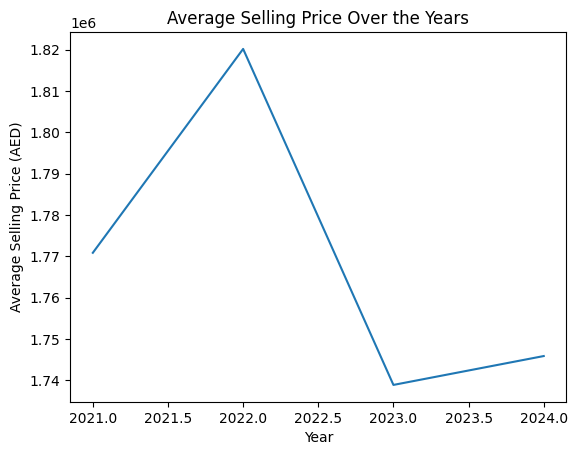

In [ ]:
#TRENDS
#trend1
#Average selling price over the years
ds.groupby('year')['selling_price'].mean().plot(
    kind='line',
    title='Average Selling Price Over the Years', xlabel='Year',
    ylabel='Average Selling Price (AED)'
)







<Axes: title={'center': 'Top 10 Areas by Sales Volume'}, xlabel='Number of Transactions', ylabel='Area Name'>

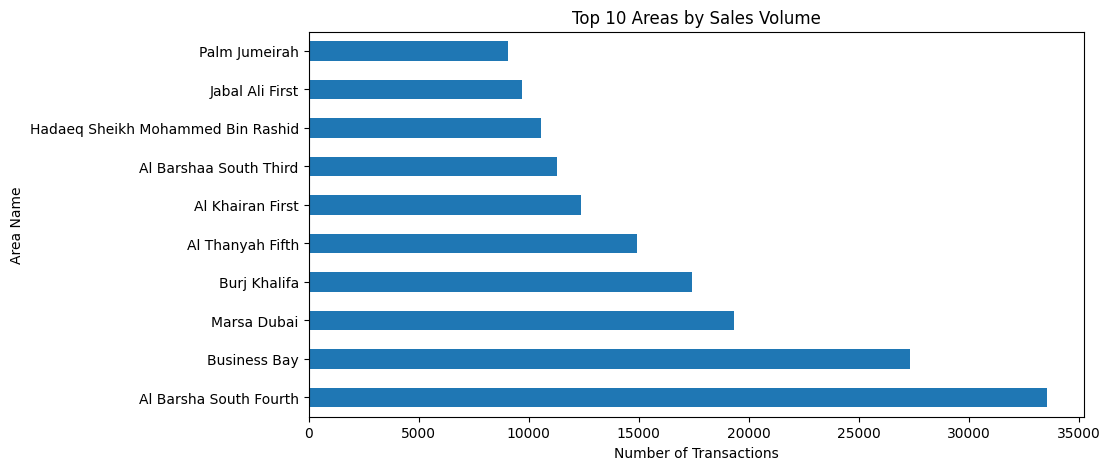

In [5]:
#trend2
#Top 10 Areas by sales volume
#insights from property sales or transactions happened in each area
ds['area_name'].value_counts().head(10).plot(kind='barh', figsize=(10,5),
 title='Top 10 Areas by Sales Volume',
xlabel='Number of Transactions',
    ylabel='Area Name'
)

<Axes: title={'center': 'Top 10 Most Expensive Areas'}, xlabel='Average Selling Price (AED)', ylabel='Area Name'>

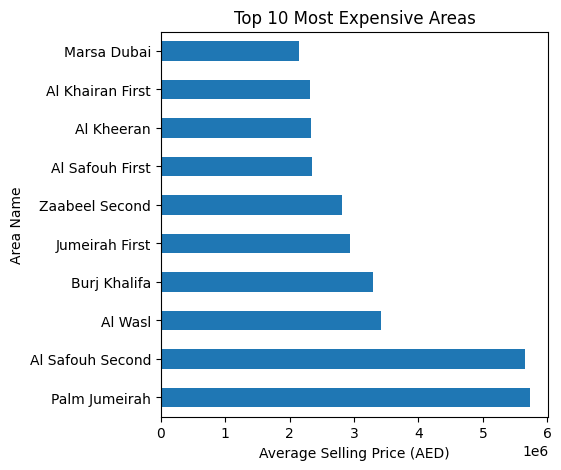

In [6]:
#trend3
ds.groupby('area_name')['selling_price'].mean()\
  .sort_values(ascending=False).head(10).plot(kind='barh',
     figsize=(5,5),
     title='Top 10 Most Expensive Areas',xlabel='Average Selling Price (AED)',
          ylabel='Area Name'
 )






Text(0, 0.5, 'Selling Price')

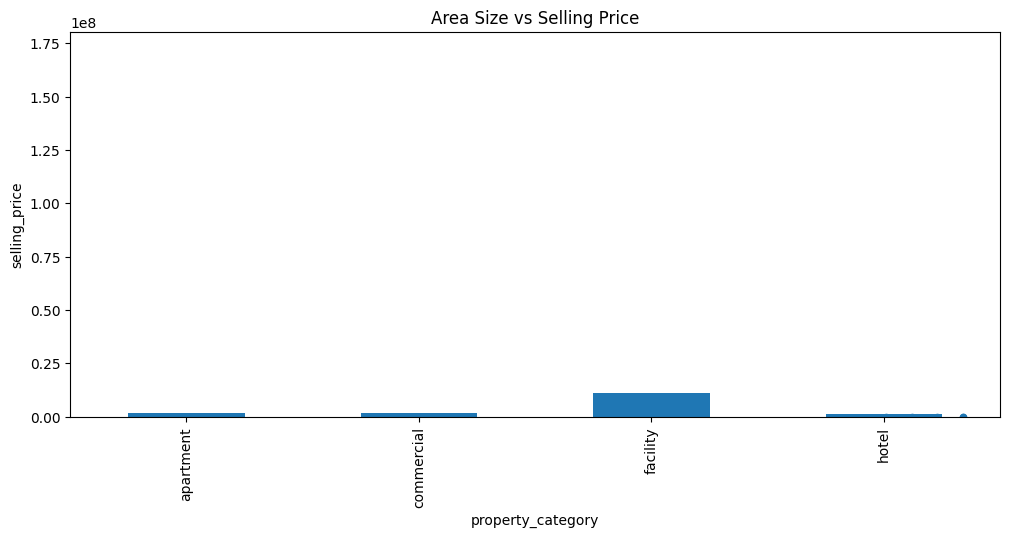

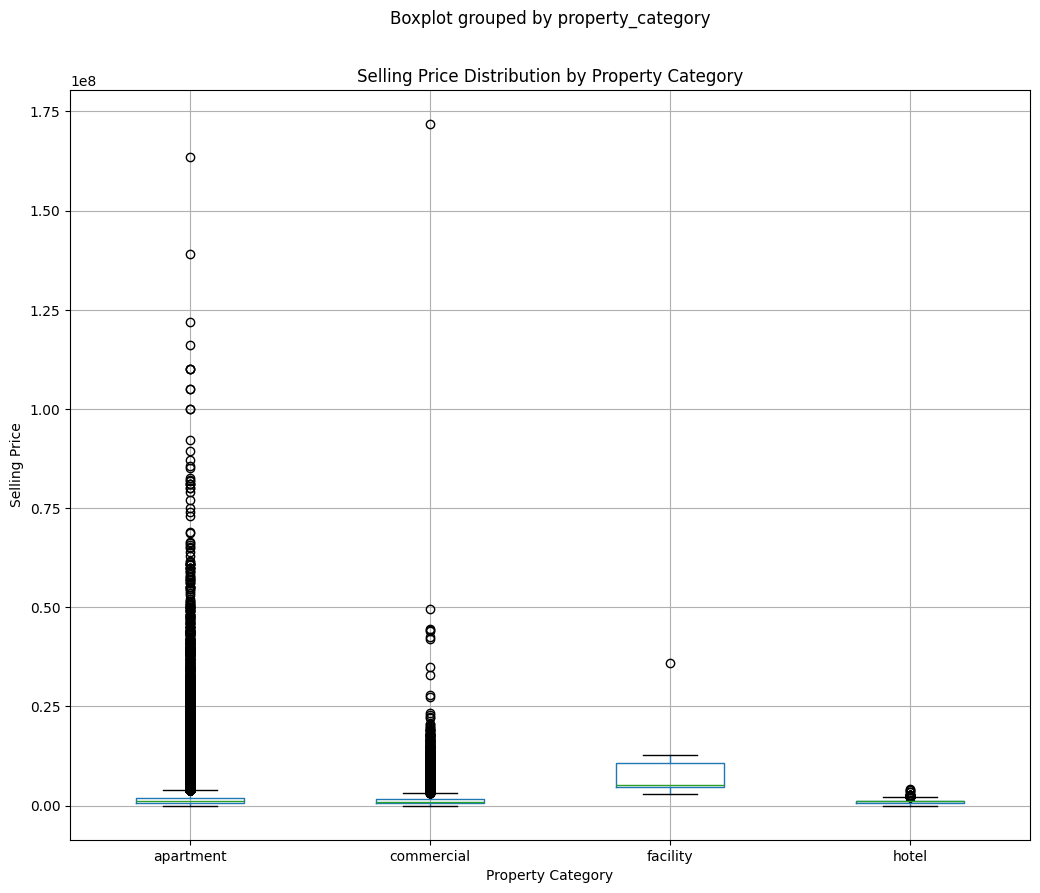

In [7]:
ds.plot(
    x='built_up_area_(sqft)',
    y='selling_price',
    kind='scatter',
    figsize=(10,10),
    title='Area Size vs Selling Price'
)
#barchart representation of Price Comparison
ds.groupby('property_category')['selling_price'].mean().plot(kind='bar',figsize=(12,5))
#for more detailed comparison of price of apartment,hotel and commercials

ds.boxplot(
    column='selling_price',
    by='property_category',
    figsize=(12,10)
)
plt.title('Selling Price Distribution by Property Category')
plt.xlabel('Property Category')
plt.ylabel('Selling Price')

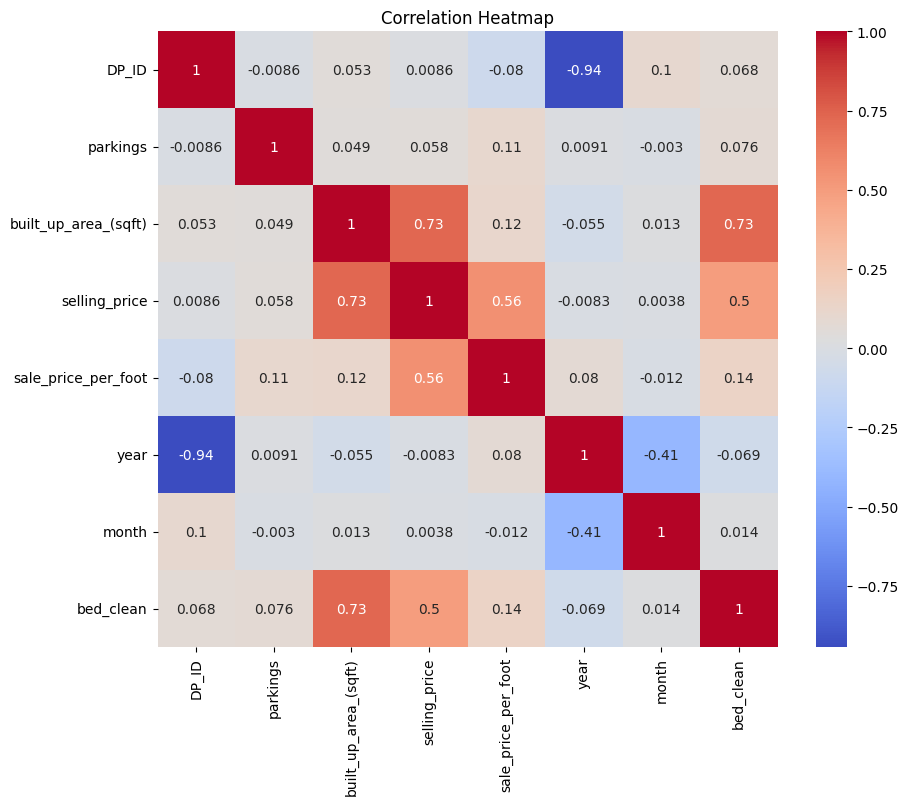

In [8]:
#checking the features  strongly related to selling_price
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(ds.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [ ]:


# 1) Columns for modelling
model_cols = [
    'selling_price',
    'built_up_area_(sqft)',
    'bed_clean',
    'parkings',
    'sale_price_per_foot',
    'year',
    'month'
]

df = ds[model_cols].copy()
for col in model_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=model_cols)
print("Rows left for modelling:", df.shape[0])



Rows left for modelling: 200749


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Define X and y
X = df.drop('selling_price', axis=1)
y = df['selling_price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----- Model 1: Linear Regression -----
lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred_lin = lin.predict(X_test)

print("Linear Regression R2:", r2_score(y_test, y_pred_lin))
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lin))

# ----- Model 2: Random Forest -----
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest R2:", r2_score(y_test, y_pred_rf))
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))


Linear Regression R2: 0.795780376886797
Linear Regression MAE: 564072.8042395001
Random Forest R2: 0.9941261766971848
Random Forest MAE: 8438.839054305883


In [ ]:
# Conclusion

# This project analysed over 200,000 property transactions in Dubai to understand
# market trends and build a machine learning model to estimate selling prices.

# Key insights:
# • Average selling prices fluctuated over the years, with peaks and corrections.
# • Palm Jumeirah, Marsa Dubai, and Al Khairan First were among the most expensive areas.
# • Built-up area and price per square foot had the strongest correlation with selling price.
# • Apartments dominated transaction volume compared to villas and hotel units.

# Model Performance:
# • Linear Regression achieved R² = 0.79 with high error due to non-linear patterns.
# • Random Forest performed extremely well with R² = 0.99 and low MAE (~8,400 AED).

# The Random Forest model was able to learn complex non-linear relationships and provides
# a reliable tool for estimating property selling prices given features such as area size,
# number of bedrooms, parking spaces, price per foot, and date.


# Example prediction for a NEW property

new_property = pd.DataFrame({
    'built_up_area_(sqft)': [1800],
    'bed_clean': [2],
    'parkings': [1],
    'sale_price_per_foot': [1500],
    'year': [2024],
    'month': [5]
})

predicted_price = rf.predict(new_property)
print("Predicted Selling Price (AED):", predicted_price[0])


Predicted Selling Price (AED): 2701830.935
